# Event-study

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import wrds
import re
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm.notebook import tqdm
import dask
dask.config.set(scheduler="processes")
from tqdm.dask import TqdmCallback
from linearmodels.system import SUR
import seaborn as sns
import plotly.graph_objects as go
from collections import OrderedDict
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.ticker as mtick
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

In [4]:
#import functions from functions.py
from function_definitions import *

## Regress CARs on firm characteristics

### SURE

In [4]:
#load returns
returns = pd.read_csv('../data/event_study/excess_returns.csv', index_col = 'date')
returns.index = pd.to_datetime(returns.index)

#load refinitiv data
refinitiv_data = pd.read_csv('../data/event_study/refinitiv_data.csv')
refinitiv_data.Date_day = pd.to_datetime(refinitiv_data.Date_day)

#load market caps
mkt_caps = pd.read_csv('../data/event_study/market_caps.csv', index_col = 'date')
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#load ratios and firm age
book_to_market = pd.read_csv('../data/event_study/book_to_market.csv', index_col = 'date')
book_to_market.index = pd.to_datetime(book_to_market.index)
firm_age = pd.read_csv('../data/event_study/firm_age.csv', index_col = 'date')
firm_age.index = pd.to_datetime(firm_age.index)
PE = pd.read_csv('../data/event_study/pe_ratio.csv', index_col = 'date')
PE.index = pd.to_datetime(PE.index)

#load the event dataframe
event_df = pd.read_csv('../data/event_study/event_df.csv', index_col = 'date')
event_df.index = pd.to_datetime(event_df.index)

#load CARs
CAR = pd.read_csv('../data/event_study/CAR_SURE.csv', index_col = ['CUSIP','event'])

In [5]:
#build the indicator vectors for each event of each firm
event_indicator = {}
indexing_date = {}
indexing_index = {}
nb_events_dropped_mkt_cap = 0
nb_events_dropped_large_day_delta = 0
nb_events_dropped_exception  = 0
total_events = 0
not_dropped = 0

for firm in tqdm(returns.columns, desc = 'Building event indicator vectors'):
    events = refinitiv_data[refinitiv_data.CUSIP == firm].Date_day.values
    precise_events = refinitiv_data[refinitiv_data.CUSIP == firm].Date.values
    nb_events = len(events)

    df = pd.DataFrame(np.zeros([returns.shape[0],nb_events*11]), index = returns.index,
                      columns = [f"event{i//11}_day{(i%11)-5:+}" for i in range(nb_events*11)])
    
    retained = []
    closest_indexes = []
    for i,event in enumerate(events):
        event = pd.to_datetime(event)
        
        if firm == '30303M10' and i == 9:
            closest_indexes.append(None)
            continue #overlaps with another cyber event
        
        total_events += 1
        
        #the day of the event could be a holiday or weekend,
        #hence find the first trading day after the event and use
        #a 3 day window around that day
        timedelta = (event-df.index)
        try:
            closest_index = min((j for j, td in enumerate(timedelta) if td.total_seconds() <= 0))
                                 #key=lambda j: abs(timedelta[j].total_seconds()))
            
            #if after trading hours, take the next day
            if pd.to_datetime(precise_events[i]).hour > 16:
                closest_index +=1
            
            #do not consider events pertaining to low mkt cap firms
            if mkt_caps[firm].iloc[closest_index] < 300e6:
                nb_events_dropped_mkt_cap += 1 
                closest_indexes.append(None)
                continue
            
            #drop if the window is larger than 5 days
            nb_actual_days = (df.index[closest_index+1]-df.index[closest_index-1]).days+1
            if nb_actual_days > 5:
                nb_events_dropped_large_day_delta += 1
                closest_indexes.append(None)
                continue
            
            #variante 2: 3 vectors per event with a single one each
            df.iloc[closest_index,   i*11+5] = 1 #event day
            df.iloc[closest_index-1, i*11+4] = 1
            df.iloc[closest_index+1, i*11+6] = 1
            
            #extra window for analysis
            df.iloc[closest_index-2, i*11+3] = 1
            df.iloc[closest_index-3, i*11+2] = 1
            df.iloc[closest_index-4, i*11+1] = 1
            df.iloc[closest_index-5, i*11] = 1
            
            df.iloc[closest_index+2, i*11+7] = 1
            df.iloc[closest_index+3, i*11+8] = 1
            df.iloc[closest_index+4, i*11+9] = 1
            df.iloc[closest_index+5, i*11+10] = 1
            
            closest_indexes.append(closest_index)
            retained.append(i)
            
            not_dropped +=1
            
        except:
            closest_indexes.append(None)
            nb_events_dropped_exception +=1
            if event.year != 2023:
                firm_ = firm
                event_ = event
            
            
    # Drop the columns with all zeros
    zero_columns = df.columns[(df == 0).all()]
    df = df.drop(columns=zero_columns)
    
    if df.shape[1] == 0:
        event_indicator[firm] = []
    else:
        event_indicator[firm] = df
    indexing_date[firm] = [returns.iloc[[idx],:].index[0] if idx is not None else None for idx in closest_indexes]
    indexing_index[firm] = closest_indexes

nb_events_step3 = not_dropped

Building event indicator vectors:   0%|          | 0/116 [00:00<?, ?it/s]

In [7]:
refinitiv_data = refinitiv_data.rename(columns = {'TRBC Economic Sector Name':'Sector'})
temp_ref = pd.get_dummies(refinitiv_data, columns = ['Sector'], drop_first=True)

data_with_dummies = temp_ref[['CUSIP','Data Breach', 'Software Breach', 'Cyber breach', 'Social breach',
                              'Ransomware', 'Shutdown', 'Twitter breach', 'Facebook breach','Stolen Funds',
                              'Mitigation','Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals',
                              'Sector_Energy', 'Sector_Financials','Sector_Healthcare', 'Sector_Industrials',
                              'Sector_Real Estate','Sector_Technology']].replace(np.nan,0)
characteristics = pd.DataFrame(np.ones((CAR.shape[0],data_with_dummies.shape[1]-1))*np.nan, index = CAR.index,
                               columns = ['Data Breach', 'Software Breach', 'Cyber breach', 'Social breach',
                                          'Ransomware', 'Shutdown', 'Twitter breach', 'Facebook breach',
                                          'Stolen Funds', 'Mitigation','Sector_Consumer Cyclicals',
                                          'Sector_Consumer Non-Cyclicals','Sector_Energy', 'Sector_Financials',
                                          'Sector_Healthcare', 'Sector_Industrials','Sector_Real Estate',
                                          'Sector_Technology'])

for firm in CAR.index.get_level_values(0):
    for event in CAR.loc[[firm]].index.get_level_values(1).astype(int):
        temp = data_with_dummies[data_with_dummies.CUSIP == firm].iloc[event]
        characteristics.loc[(firm, event)] = temp[['Data Breach', 'Software Breach', 'Cyber breach',
                                                       'Social breach','Ransomware', 'Shutdown', 'Twitter breach',
                                                       'Facebook breach','Stolen Funds', 'Mitigation',
                                                        'Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals',
                                                        'Sector_Energy', 'Sector_Financials','Sector_Healthcare',
                                                        'Sector_Industrials','Sector_Real Estate',
                                                        'Sector_Technology']]
        #mkt_cap_event.loc[(firm, event)] = np.log(mkt_caps.loc[indexing_date[firm][event],firm])
        
characteristics = characteristics.loc[:,~characteristics.sum().eq(0)]

In [8]:
#Variance inflation factor
X = sm.add_constant(characteristics.loc[:,characteristics.sum()>4])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
#less than 5 -> good

const                        23.095136
Data Breach                   3.283941
Software Breach               2.791595
Social breach                 1.109753
Ransomware                    1.182097
Shutdown                      1.713316
Twitter breach                2.680086
Facebook breach               1.553117
Mitigation                    1.514365
Sector_Consumer Cyclicals     3.138278
Sector_Industrials            1.826958
Sector_Technology             4.016414
dtype: float64

In [9]:
sm.OLS(CAR*100, characteristics.filter(like = 'Sector')).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 params   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.2951
Date:                Wed, 22 Nov 2023   Prob (F-statistic):              0.938
Time:                        17:41:15   Log-Likelihood:                -338.24
No. Observations:                 126   AIC:                             690.5
Df Residuals:                     119   BIC:                             710.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Sector_Consumer Cyclicals        -0.6216      0.761     -0.817      0.415      -2.128       0.884
Sector_Consumer Non-Cyclicals     1.6256      2.579      0.630      0.530      -3.482       6.733
Sector_Financials                 0.6901      2.106      0.328      0.744      -3.480       4.860
Sector_Healthcare                -1.0821      2.106     -0.514      0.608      -5.252       3.088
Sector_Industrials               -1.4911      1.290     -1.156      0.250      -4.045       1.063
Sector_Real Estate               -1.2929      3.648     -0.354      0.724      -8.516       5.930
Sector_Technology                -0.8433      0.393     -2.144      0.034      -1.622      -0.064
==============================================================================
Omnibus:                       21.864   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.667
Skew:                           0.767   Prob(JB):                     2.43e-09
Kurtosis:                       5.281   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
sm.OLS(CAR*100, characteristics.iloc[:,:10]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 params   R-squared (uncentered):                   0.085
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              1.081
Date:                Wed, 22 Nov 2023   Prob (F-statistic):                       0.383
Time:                        17:41:16   Log-Likelihood:                         -336.48
No. Observations:                 126   AIC:                                      693.0
Df Residuals:                     116   BIC:                                      721.3
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Data Breach        -1.1784      0.560     -2.106      0.037      -2.287      -0.070
Software Breach    -0.1781      0.615     -0.290      0.773      -1.396       1.040
Cyber breach        1.2704      3.643      0.349      0.728      -5.945       8.486
Social breach      -0.0864      1.420     -0.061      0.952      -2.898       2.725
Ransomware         -0.8507      1.207     -0.705      0.482      -3.241       1.540
Shutdown           -0.7532      1.008     -0.747      0.456      -2.750       1.243
Twitter breach     -0.6833      0.836     -0.817      0.416      -2.340       0.973
Facebook breach     1.7865      1.629      1.096      0.275      -1.441       5.014
Stolen Funds       -0.6173      2.672     -0.231      0.818      -5.910       4.675
Mitigation          1.7638      1.629      1.083      0.281      -1.463       4.991
==============================================================================
Omnibus:                       16.164   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.340
Skew:                           0.682   Prob(JB):                     1.41e-05
Kurtosis:                       4.548   Cond. No.                         7.19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
characteristics2 = characteristics.iloc[:,:10].copy()
characteristics2['Other'] = characteristics2.loc[:,~characteristics2.columns.isin(['Data Breach'])].sum(1).clip(upper = 1)
characteristics2 = characteristics2[['Data Breach', 'Other']]
characteristics2 = pd.concat([characteristics2, CAR*100],axis = 1)
characteristics2 = pd.concat([characteristics2, characteristics.filter(like = 'Sector')], axis = 1)
characteristics2['Consumer products'] = characteristics2.loc[:,['Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals']].sum(1).clip(upper = 1)
characteristics2 = characteristics2.loc[:,~characteristics2.columns.isin(['Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals'])]
characteristics2.columns = ['Data_breach','Other','CAR','financials','healthcare',
                            'industrials', 'real', 'tech', 'cons_products']

In [12]:
smf.ols(formula = 'CAR ~ Other \
                   + Data_breach * cons_products \
                   + Data_breach * financials + Data_breach * healthcare \
                   + Data_breach * industrials + Data_breach * tech - 1', data = characteristics2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    CAR   R-squared (uncentered):                   0.109
Model:                            OLS   Adj. R-squared (uncentered):              0.032
Method:                 Least Squares   F-statistic:                              1.416
Date:                Wed, 22 Nov 2023   Prob (F-statistic):                       0.182
Time:                        17:41:17   Log-Likelihood:                         -334.83
No. Observations:                 126   AIC:                                      689.7
Df Residuals:                     116   BIC:                                      718.0
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Other                         0.4223      1.175      0.360      0.720      -1.904       2.749
Data_breach                  -1.2200      1.205     -1.013      0.313      -3.606       1.166
cons_products                -0.2720      1.635     -0.166      0.868      -3.510       2.966
Data_breach:cons_products     0.5991      1.578      0.380      0.705      -2.527       3.725
financials                    0.9551      1.116      0.856      0.394      -1.255       3.165
Data_breach:financials        0.9551      1.116      0.856      0.394      -1.255       3.165
healthcare                    1.3993      2.801      0.500      0.618      -4.148       6.947
Data_breach:healthcare       -7.0686      3.687     -1.917      0.058     -14.372       0.235
industrials                  -3.4710      2.385     -1.455      0.148      -8.195       1.254
Data_breach:industrials       3.9656      2.322      1.708      0.090      -0.633       8.564
tech                         -0.9230      1.262     -0.732      0.466      -3.422       1.576
Data_breach:tech              0.3288      1.217      0.270      0.787      -2.081       2.739
==============================================================================
Omnibus:                       20.357   Durbin-Watson:                   1.470
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.298
Skew:                           0.746   Prob(JB):                     3.57e-08
Kurtosis:                       5.075   Cond. No.                     4.68e+17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 7.75e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
years = []
for cusip, idx in CAR.index:
    years.append(refinitiv_data[refinitiv_data.CUSIP == cusip].iloc[idx].Date_day.year)
years = pd.DataFrame(years, columns = ['years'], index = CAR.index)

sm.OLS(CAR*100, pd.get_dummies(years, columns = ['years'], drop_first = True)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 params   R-squared (uncentered):                   0.084
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              1.355
Date:                Wed, 22 Nov 2023   Prob (F-statistic):                       0.223
Time:                        17:41:17   Log-Likelihood:                         -336.55
No. Observations:                 126   AIC:                                      689.1
Df Residuals:                     118   BIC:                                      711.8
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
years_2015    -0.8996      1.366     -0.659      0.511      -3.605       1.806
years_2016    -1.7603      1.002     -1.756      0.082      -3.745       0.225
years_2017    -0.6620      0.933     -0.709      0.479      -2.510       1.186
years_2018    -1.7901      0.904     -1.981      0.050      -3.579      -0.001
years_2019    -0.0277      1.278     -0.022      0.983      -2.558       2.503
years_2020     0.4446      0.808      0.550      0.583      -1.156       2.045
years_2021    -1.5270      0.966     -1.581      0.117      -3.440       0.386
years_2022    -0.2277      0.738     -0.309      0.758      -1.689       1.233
==============================================================================
Omnibus:                       16.553   Durbin-Watson:                   1.629
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.940
Skew:                           0.655   Prob(JB):                     3.84e-06
Kurtosis:                       4.741   Cond. No.                         1.85
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
temp_ref = pd.get_dummies(refinitiv_data, columns = ['Source'], drop_first=True)

data_with_dummies = temp_ref[['CUSIP','Source_RTRS','Source_TWTR']].replace(np.nan,0)
characteristics = pd.DataFrame(np.ones((CAR.shape[0],data_with_dummies.shape[1]-1))*np.nan, index = CAR.index,
                               columns = ['Source_RTRS','Source_TWTR'])

for firm in CAR.index.get_level_values(0):
    for event in CAR.loc[[firm]].index.get_level_values(1).astype(int):
        temp = data_with_dummies[data_with_dummies.CUSIP == firm].iloc[event]
        characteristics.loc[(firm, event)] = temp[['Source_RTRS','Source_TWTR']]
        
characteristics = characteristics.loc[:,~characteristics.sum().eq(0)]

In [15]:
sm.OLS(CAR*100, sm.add_constant(characteristics)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 params   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.3413
Date:                Wed, 22 Nov 2023   Prob (F-statistic):              0.712
Time:                        17:41:18   Log-Likelihood:                -338.83
No. Observations:                 126   AIC:                             683.7
Df Residuals:                     123   BIC:                             692.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.4725      0.510     -0.927      0.356      -1.482       0.537
Source_RTRS    -0.4767      0.664     -0.718      0.474      -1.790       0.837
Source_TWTR    -1.0285      1.873     -0.549      0.584      -4.736       2.679
==============================================================================
Omnibus:                       24.014   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.946
Skew:                           0.809   Prob(JB):                     6.39e-11
Kurtosis:                       5.515   Cond. No.                         6.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
mkt_cap_event = pd.DataFrame(np.ones((CAR.shape[0]))*np.nan, index = CAR.index,
                               columns = ['mkt_cap'])
book_to_market_event = pd.DataFrame(np.ones((CAR.shape[0]))*np.nan, index = CAR.index,
                               columns = ['book_to_market'])
firm_age_event = pd.DataFrame(np.ones((CAR.shape[0]))*np.nan, index = CAR.index,
                               columns = ['firm_age'])
PE_ratio_event = pd.DataFrame(np.ones((CAR.shape[0]))*np.nan, index = CAR.index,
                               columns = ['PE'])
for firm in CAR.index.get_level_values(0):
    for event in CAR.loc[[firm]].index.get_level_values(1).astype(int):
        try:
            mkt_cap_event.loc[(firm, event)] = np.log(mkt_caps.loc[indexing_date[firm][event],firm])
            book_to_market_event.loc[(firm, event)] = book_to_market.loc[indexing_date[firm][event],firm]
            firm_age_event.loc[(firm, event)] = np.log(firm_age.loc[indexing_date[firm][event],firm])
            PE_ratio_event.loc[(firm, event)] = PE.loc[indexing_date[firm][event],firm]
        except: None

ratios = pd.concat([mkt_cap_event,book_to_market_event,firm_age_event,PE_ratio_event], axis = 1)
ratios = ratios.dropna()

In [17]:
sm.OLS(CAR.loc[ratios.index,:]*100, sm.add_constant(ratios)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 params   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.255
Date:                Wed, 22 Nov 2023   Prob (F-statistic):             0.0676
Time:                        17:41:19   Log-Likelihood:                -312.98
No. Observations:                 117   AIC:                             636.0
Df Residuals:                     112   BIC:                             649.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -7.8719      4.681     -1.682      0.095     -17.146       1.403
mkt_cap            0.3477      0.185      1.881      0.063      -0.019       0.714
book_to_market    -0.0347      0.141     -0.247      0.805      -0.313       0.244
firm_age          -0.4139      0.437     -0.946      0.346      -1.281       0.453
PE                -0.0152      0.007     -2.164      0.033      -0.029      -0.001
==============================================================================
Omnibus:                        9.418   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.370
Skew:                           0.473   Prob(JB):                      0.00340
Kurtosis:                       4.199   Cond. No.                         717.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### OLS

In [46]:
#load CARs
CAR = pd.read_csv('../data/event_study/CAR_OLS.csv', index_col = ['CUSIP','event'])

In [47]:
refinitiv_data = refinitiv_data.rename(columns = {'TRBC Economic Sector Name':'Sector'})
temp_ref = pd.get_dummies(refinitiv_data, columns = ['Sector'], drop_first=True)

data_with_dummies = temp_ref[['CUSIP','Data Breach', 'Software Breach', 'Cyber breach', 'Social breach',
                              'Ransomware', 'Shutdown', 'Twitter breach', 'Facebook breach','Stolen Funds',
                              'Mitigation','Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals',
                              'Sector_Energy', 'Sector_Financials','Sector_Healthcare', 'Sector_Industrials',
                              'Sector_Real Estate','Sector_Technology']].replace(np.nan,0)
characteristics = pd.DataFrame(np.ones((CAR.shape[0],data_with_dummies.shape[1]-1))*np.nan, index = CAR.index,
                               columns = ['Data Breach', 'Software Breach', 'Cyber breach', 'Social breach',
                                          'Ransomware', 'Shutdown', 'Twitter breach', 'Facebook breach',
                                          'Stolen Funds', 'Mitigation','Sector_Consumer Cyclicals',
                                          'Sector_Consumer Non-Cyclicals','Sector_Energy', 'Sector_Financials',
                                          'Sector_Healthcare', 'Sector_Industrials','Sector_Real Estate',
                                          'Sector_Technology'])

for firm in CAR.index.get_level_values(0):
    for event in CAR.loc[[firm]].index.get_level_values(1).astype(int):
        temp = data_with_dummies[data_with_dummies.CUSIP == firm].iloc[event]
        characteristics.loc[(firm, event)] = temp[['Data Breach', 'Software Breach', 'Cyber breach',
                                                       'Social breach','Ransomware', 'Shutdown', 'Twitter breach',
                                                       'Facebook breach','Stolen Funds', 'Mitigation',
                                                        'Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals',
                                                        'Sector_Energy', 'Sector_Financials','Sector_Healthcare',
                                                        'Sector_Industrials','Sector_Real Estate',
                                                        'Sector_Technology']]
        #mkt_cap_event.loc[(firm, event)] = np.log(mkt_caps.loc[indexing_date[firm][event],firm])
        
characteristics = characteristics.loc[:,~characteristics.sum().eq(0)]
characteristics = pd.concat([characteristics,mkt_cap_event], axis = 1)

In [48]:
sm.OLS(CAR*100, characteristics.filter(like = 'Sector')).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 params   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.688
Date:                Thu, 23 Nov 2023   Prob (F-statistic):              0.127
Time:                        09:55:27   Log-Likelihood:                -505.97
No. Observations:                 167   AIC:                             1026.
Df Residuals:                     160   BIC:                             1048.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Sector_Consumer Cyclicals         1.1384      0.967      1.178      0.241      -0.771       3.048
Sector_Consumer Non-Cyclicals     1.7354      3.617      0.480      0.632      -5.408       8.879
Sector_Financials                -0.2148      2.088     -0.103      0.918      -4.339       3.909
Sector_Healthcare                -4.5216      1.618     -2.795      0.006      -7.716      -1.327
Sector_Industrials               -1.4773      1.419     -1.041      0.299      -4.279       1.325
Sector_Real Estate               -0.1933      5.115     -0.038      0.970     -10.296       9.909
Sector_Technology                -0.8755      0.495     -1.770      0.079      -1.852       0.101
==============================================================================
Omnibus:                       32.907   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.739
Skew:                           0.570   Prob(JB):                     6.81e-34
Kurtosis:                       7.544   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
sm.OLS(CAR*100, characteristics.iloc[:,:10]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 params   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):             -0.019
Method:                 Least Squares   F-statistic:                             0.6909
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                       0.732
Time:                        09:55:27   Log-Likelihood:                         -509.22
No. Observations:                 167   AIC:                                      1038.
Df Residuals:                     157   BIC:                                      1070.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Data Breach        -1.2873      0.675     -1.907      0.058      -2.621       0.046
Software Breach    -0.3804      0.792     -0.480      0.632      -1.945       1.185
Cyber breach        1.1523      2.633      0.438      0.662      -4.048       6.352
Social breach       0.0811      1.782      0.045      0.964      -3.439       3.601
Ransomware          0.3952      1.534      0.258      0.797      -2.635       3.425
Shutdown           -0.4364      1.075     -0.406      0.685      -2.561       1.688
Twitter breach     -0.8460      1.209     -0.700      0.485      -3.233       1.541
Facebook breach     2.3781      2.355      1.010      0.314      -2.273       7.029
Stolen Funds        0.3618      2.671      0.135      0.892      -4.913       5.637
Mitigation          1.7619      2.355      0.748      0.455      -2.889       6.413
==============================================================================
Omnibus:                       38.175   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.452
Skew:                           0.551   Prob(JB):                     2.78e-57
Kurtosis:                       9.018   Cond. No.                         4.32
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
characteristics2 = characteristics.iloc[:,:10].copy()
characteristics2['Other'] = characteristics2.loc[:,~characteristics2.columns.isin(['Data Breach'])].sum(1).clip(upper = 1)
characteristics2 = characteristics2[['Data Breach', 'Other']]
characteristics2 = pd.concat([characteristics2, CAR*100],axis = 1)
characteristics2 = pd.concat([characteristics2, characteristics.filter(like = 'Sector')], axis = 1)
characteristics2['Consumer products'] = characteristics2.loc[:,['Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals']].sum(1).clip(upper = 1)
characteristics2 = characteristics2.loc[:,~characteristics2.columns.isin(['Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals'])]
characteristics2.columns = ['Data_breach','Other','CAR','financials','healthcare',
                            'industrials', 'real', 'tech', 'cons_products']

In [51]:
smf.ols(formula = 'CAR ~ Other \
                   + Data_breach * cons_products \
                   + Data_breach * financials + Data_breach * healthcare \
                   + Data_breach * industrials + Data_breach * tech - 1', data = characteristics2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    CAR   R-squared (uncentered):                   0.106
Model:                            OLS   Adj. R-squared (uncentered):              0.043
Method:                 Least Squares   F-statistic:                              1.690
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                      0.0802
Time:                        09:55:27   Log-Likelihood:                         -503.41
No. Observations:                 167   AIC:                                      1029.
Df Residuals:                     156   BIC:                                      1063.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Other                         1.3621      1.418      0.960      0.338      -1.439       4.164
Data_breach                   0.2610      1.564      0.167      0.868      -2.828       3.350
cons_products                 1.5609      1.967      0.793      0.429      -2.325       5.447
Data_breach:cons_products    -2.3407      1.995     -1.173      0.242      -6.281       1.600
financials                   -3.8250      5.295     -0.722      0.471     -14.285       6.635
Data_breach:financials        3.7989      4.756      0.799      0.426      -5.595      13.193
healthcare                   -5.2098      3.269     -1.594      0.113     -11.667       1.248
Data_breach:healthcare       -0.2508      3.136     -0.080      0.936      -6.445       5.943
industrials                  -1.7126      2.520     -0.680      0.498      -6.690       3.265
Data_breach:industrials      -1.3805      2.635     -0.524      0.601      -6.584       3.823
tech                         -2.1719      1.537     -1.413      0.160      -5.208       0.865
Data_breach:tech              0.4341      1.525      0.285      0.776      -2.578       3.446
==============================================================================
Omnibus:                       22.803   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.925
Skew:                           0.309   Prob(JB):                     4.02e-21
Kurtosis:                       6.622   Cond. No.                     2.01e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 5.33e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [52]:
years = []
for cusip, idx in CAR.index:
    years.append(refinitiv_data[refinitiv_data.CUSIP == cusip].iloc[idx].Date_day.year)
years = pd.DataFrame(years, columns = ['years'], index = CAR.index)

sm.OLS(CAR*100, pd.get_dummies(years, columns = ['years'], drop_first = True)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 params   R-squared (uncentered):                   0.050
Model:                            OLS   Adj. R-squared (uncentered):             -0.010
Method:                 Least Squares   F-statistic:                             0.8308
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                       0.600
Time:                        09:55:27   Log-Likelihood:                         -508.51
No. Observations:                 167   AIC:                                      1037.
Df Residuals:                     157   BIC:                                      1068.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
years_2013     0.5568      1.658      0.336      0.737      -2.718       3.832
years_2014    -0.0289      1.658     -0.017      0.986      -3.304       3.246
years_2015    -1.1094      1.854     -0.598      0.550      -4.771       2.552
years_2016    -1.0191      1.401     -0.727      0.468      -3.787       1.749
years_2017    -0.3241      1.236     -0.262      0.793      -2.765       2.117
years_2018    -1.5360      1.236     -1.243      0.216      -3.977       0.905
years_2019    -0.6514      1.514     -0.430      0.668      -3.641       2.338
years_2020    -0.2678      1.028     -0.260      0.795      -2.299       1.763
years_2021    -1.7993      1.236     -1.456      0.147      -4.240       0.642
years_2022    -1.7161      0.942     -1.822      0.070      -3.576       0.144
==============================================================================
Omnibus:                       36.404   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.525
Skew:                           0.539   Prob(JB):                     3.92e-50
Kurtosis:                       8.616   Cond. No.                         1.97
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
temp_ref = pd.get_dummies(refinitiv_data, columns = ['Source'], drop_first=True)

data_with_dummies = temp_ref[['CUSIP','Source_RTRS','Source_TWTR']].replace(np.nan,0)
characteristics = pd.DataFrame(np.ones((CAR.shape[0],data_with_dummies.shape[1]-1))*np.nan, index = CAR.index,
                               columns = ['Source_RTRS','Source_TWTR'])

for firm in CAR.index.get_level_values(0):
    for event in CAR.loc[[firm]].index.get_level_values(1).astype(int):
        temp = data_with_dummies[data_with_dummies.CUSIP == firm].iloc[event]
        characteristics.loc[(firm, event)] = temp[['Source_RTRS','Source_TWTR']]
        
characteristics = characteristics.loc[:,~characteristics.sum().eq(0)]

In [54]:
sm.OLS(CAR*100, sm.add_constant(characteristics)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 params   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.09066
Date:                Thu, 23 Nov 2023   Prob (F-statistic):              0.913
Time:                        09:55:29   Log-Likelihood:                -511.01
No. Observations:                 167   AIC:                             1028.
Df Residuals:                     164   BIC:                             1037.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.8397      0.678     -1.239      0.217      -2.178       0.499
Source_RTRS     0.1862      0.849      0.219      0.827      -1.490       1.862
Source_TWTR    -0.8429      2.690     -0.313      0.754      -6.155       4.469
==============================================================================
Omnibus:                       38.702   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.829
Skew:                           0.572   Prob(JB):                     3.79e-57
Kurtosis:                       9.003   Cond. No.                         8.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
mkt_cap_event = pd.DataFrame(np.ones((CAR.shape[0]))*np.nan, index = CAR.index,
                               columns = ['mkt_cap'])
book_to_market_event = pd.DataFrame(np.ones((CAR.shape[0]))*np.nan, index = CAR.index,
                               columns = ['book_to_market'])
firm_age_event = pd.DataFrame(np.ones((CAR.shape[0]))*np.nan, index = CAR.index,
                               columns = ['firm_age'])
PE_ratio_event = pd.DataFrame(np.ones((CAR.shape[0]))*np.nan, index = CAR.index,
                               columns = ['PE'])
for firm in CAR.index.get_level_values(0):
    for event in CAR.loc[[firm]].index.get_level_values(1).astype(int):
        try:
            mkt_cap_event.loc[(firm, event)] = np.log(mkt_caps.loc[indexing_date[firm][event],firm])
            book_to_market_event.loc[(firm, event)] = book_to_market.loc[indexing_date[firm][event],firm]
            firm_age_event.loc[(firm, event)] = np.log(firm_age.loc[indexing_date[firm][event],firm])
            PE_ratio_event.loc[(firm, event)] = PE.loc[indexing_date[firm][event],firm]
        except: None

ratios = pd.concat([mkt_cap_event,book_to_market_event,firm_age_event,PE_ratio_event], axis = 1)
ratios = ratios.dropna()

In [56]:
sm.OLS(CAR.loc[ratios.index,:]*100, sm.add_constant(ratios)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 params   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6273
Date:                Thu, 23 Nov 2023   Prob (F-statistic):              0.644
Time:                        09:55:29   Log-Likelihood:                -445.43
No. Observations:                 150   AIC:                             900.9
Df Residuals:                     145   BIC:                             915.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -6.0400      5.131     -1.177      0.241     -16.181       4.101
mkt_cap            0.2060      0.207      0.994      0.322      -0.204       0.616
book_to_market    -0.0651      0.141     -0.463      0.644      -0.343       0.213
firm_age           0.1547      0.467      0.332      0.741      -0.768       1.077
PE                 0.0010      0.009      0.115      0.909      -0.016       0.018
==============================================================================
Omnibus:                       20.215   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.455
Skew:                           0.304   Prob(JB):                     2.50e-17
Kurtosis:                       6.444   Cond. No.                         640.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Price of cyber incidents

In [128]:
#load CARs
CAR = pd.read_csv('../data/event_study/CAR_OLS.csv', index_col = ['CUSIP','event'])

#load market caps
mkt_caps = pd.read_csv('../data/event_study/market_caps.csv', index_col = 'date')
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#load returns
returns = pd.read_csv('../data/event_study/excess_returns.csv', index_col = 'date')
returns.index = pd.to_datetime(returns.index)

#load refinitiv data
refinitiv_data = pd.read_csv('../data/event_study/refinitiv_data.csv')
refinitiv_data.Date_day = pd.to_datetime(refinitiv_data.Date_day)

#load the event dataframe
event_df = pd.read_csv('../data/event_study/event_df.csv', index_col = 'date')
event_df.index = pd.to_datetime(event_df.index)

#load refinitiv data
refinitiv_data = pd.read_csv('../data/event_study/refinitiv_data.csv')
refinitiv_data.Date_day = pd.to_datetime(refinitiv_data.Date_day)

In [129]:
#build the indicator vectors for each event of each firm
event_indicator = {}
indexing_date = {}
indexing_index = {}
nb_events_dropped_mkt_cap = 0
nb_events_dropped_large_day_delta = 0
nb_events_dropped_exception  = 0
total_events = 0
not_dropped = 0

for firm in tqdm(returns.columns, desc = 'Building event indicator vectors'):
    events = refinitiv_data[refinitiv_data.CUSIP == firm].Date_day.values
    precise_events = refinitiv_data[refinitiv_data.CUSIP == firm].Date.values
    nb_events = len(events)

    df = pd.DataFrame(np.zeros([returns.shape[0],nb_events*11]), index = returns.index,
                      columns = [f"event{i//11}_day{(i%11)-5:+}" for i in range(nb_events*11)])
    
    retained = []
    closest_indexes = []
    for i,event in enumerate(events):
        event = pd.to_datetime(event)
        
        if firm == '30303M10' and i == 9:
            closest_indexes.append(None)
            continue #overlaps with another cyber event
        
        total_events += 1
        
        #the day of the event could be a holiday or weekend,
        #hence find the first trading day after the event and use
        #a 3 day window around that day
        timedelta = (event-df.index)
        try:
            closest_index = min((j for j, td in enumerate(timedelta) if td.total_seconds() <= 0))
                                 #key=lambda j: abs(timedelta[j].total_seconds()))
            
            #if after trading hours, take the next day
            if pd.to_datetime(precise_events[i]).hour > 16:
                closest_index +=1
            
            #do not consider events pertaining to low mkt cap firms
            if mkt_caps[firm].iloc[closest_index] < 300e6:
                nb_events_dropped_mkt_cap += 1 
                closest_indexes.append(None)
                continue
            
            #drop if the window is larger than 5 days
            nb_actual_days = (df.index[closest_index+1]-df.index[closest_index-1]).days+1
            if nb_actual_days > 5:
                nb_events_dropped_large_day_delta += 1
                closest_indexes.append(None)
                continue
            
            #variante 2: 3 vectors per event with a single one each
            df.iloc[closest_index,   i*11+5] = 1 #event day
            df.iloc[closest_index-1, i*11+4] = 1
            df.iloc[closest_index+1, i*11+6] = 1
            
            #extra window for analysis
            df.iloc[closest_index-2, i*11+3] = 1
            df.iloc[closest_index-3, i*11+2] = 1
            df.iloc[closest_index-4, i*11+1] = 1
            df.iloc[closest_index-5, i*11] = 1
            
            df.iloc[closest_index+2, i*11+7] = 1
            df.iloc[closest_index+3, i*11+8] = 1
            df.iloc[closest_index+4, i*11+9] = 1
            df.iloc[closest_index+5, i*11+10] = 1
            
            closest_indexes.append(closest_index)
            retained.append(i)
            
            not_dropped +=1
            
        except:
            closest_indexes.append(None)
            nb_events_dropped_exception +=1
            if event.year != 2023:
                firm_ = firm
                event_ = event
            
            
    # Drop the columns with all zeros
    zero_columns = df.columns[(df == 0).all()]
    df = df.drop(columns=zero_columns)
    
    if df.shape[1] == 0:
        event_indicator[firm] = []
    else:
        event_indicator[firm] = df
    indexing_date[firm] = [returns.iloc[[idx],:].index[0] if idx is not None else None for idx in closest_indexes]
    indexing_index[firm] = closest_indexes

nb_events_step3 = not_dropped

Building event indicator vectors:   0%|          | 0/116 [00:00<?, ?it/s]

In [131]:
mkt_cap_event = pd.DataFrame(np.ones((CAR.shape[0]))*np.nan, index = CAR.index,
                               columns = ['mkt_cap'])
refinitiv_data = refinitiv_data.rename(columns = {'TRBC Economic Sector Name':'Sector'})
temp_ref = pd.get_dummies(refinitiv_data, columns = ['Sector'], drop_first=True)

data_with_dummies = temp_ref[['CUSIP','Data Breach', 'Software Breach', 'Cyber breach', 'Social breach',
                              'Ransomware', 'Shutdown', 'Twitter breach', 'Facebook breach','Stolen Funds',
                              'Mitigation','Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals',
                              'Sector_Energy', 'Sector_Financials','Sector_Healthcare', 'Sector_Industrials',
                              'Sector_Real Estate','Sector_Technology']].replace(np.nan,0)
characteristics = pd.DataFrame(np.ones((CAR.shape[0],data_with_dummies.shape[1]-1))*np.nan, index = CAR.index,
                               columns = ['Data Breach', 'Software Breach', 'Cyber breach', 'Social breach',
                                          'Ransomware', 'Shutdown', 'Twitter breach', 'Facebook breach',
                                          'Stolen Funds', 'Mitigation','Sector_Consumer Cyclicals',
                                          'Sector_Consumer Non-Cyclicals','Sector_Energy', 'Sector_Financials',
                                          'Sector_Healthcare', 'Sector_Industrials','Sector_Real Estate',
                                          'Sector_Technology'])

dates = []

for firm in CAR.index.get_level_values(0).unique():
    for event in CAR.loc[[firm]].index.get_level_values(1).astype(int):
        mkt_cap_event.loc[(firm, event)] = mkt_caps.loc[indexing_date[firm][event],firm]
        dates.append(indexing_date[firm][event])
        temp = data_with_dummies[data_with_dummies.CUSIP == firm].iloc[event]
        characteristics.loc[(firm, event)] = temp[['Data Breach', 'Software Breach', 'Cyber breach',
                                                       'Social breach','Ransomware', 'Shutdown', 'Twitter breach',
                                                       'Facebook breach','Stolen Funds', 'Mitigation',
                                                        'Sector_Consumer Cyclicals','Sector_Consumer Non-Cyclicals',
                                                        'Sector_Energy', 'Sector_Financials','Sector_Healthcare',
                                                        'Sector_Industrials','Sector_Real Estate',
                                                        'Sector_Technology']]

In [132]:
price = pd.DataFrame(CAR.values*mkt_cap_event.values, columns=['price'], index=CAR.index)
print('Total price: {:e}'.format(int(price.sum().values[0])))
print('Average price per incident: {:e}'.format(int(price.mean().values[0])))
print('Median price per incident: {:e}'.format(int(price.median().values[0])))

Total price: -2.770634e+11
Average price per incident: -1.659062e+09
Median price per incident: -1.233511e+08


In [133]:
price['dates'] = [d.year for d in dates]
print('Average annual price: {:e}'.format(int(price.groupby("dates").sum().mean())))

Average annual price: -2.518758e+10


In [140]:
price_db = price[characteristics['Data Breach'] == 1]
print('Total price of data breaches: {:e}'.format(int(price_db.sum().values[0])))
print('Average price per data breach incident: {:e}'.format(int(price_db.mean().values[0])))
print('Median price per data breach incident: {:e}'.format(int(price_db.median().values[0])))

Total price of data breaches: -1.289748e+11
Average price per data breach incident: -1.896688e+09
Median price per data breach incident: -1.049788e+08


In [142]:
price_health = price[characteristics['Sector_Healthcare'] == 1]
print('Total price for healthcare: {:e}'.format(int(price_health.sum().values[0])))
print('Average price per incident for healthcare: {:e}'.format(int(price_health.mean().values[0])))
print('Median price per incident for healthcare: {:e}'.format(int(price_health.median().values[0])))

Total price for healthcare: -1.197363e+10
Average price per incident for healthcare: -1.197363e+09
Median price per incident for healthcare: -6.495171e+07


In [143]:
price_db_h = price[(characteristics['Data Breach'] == 1) & (characteristics['Sector_Healthcare'] == 1)]
print('Total price of data breaches for healthcare: {:e}'.format(int(price_db_h.sum().values[0])))
print('Average price per data breach incident for healthcare: {:e}'.format(int(price_db_h.mean().values[0])))
print('Median price per data breach incident for healthcare: {:e}'.format(int(price_db_h.median().values[0])))

Total price of data breaches for healthcare: -1.375225e+10
Average price per data breach incident for healthcare: -1.964607e+09
Median price per data breach incident for healthcare: -8.660647e+07


## Plots

In [57]:
AR_OLS = pd.read_csv('../data/event_study/AR_OLS.csv')
AR_OLS_lim = pd.read_csv('../data/event_study/AR_OLS_limited.csv')
AR_SURE = pd.read_csv('../data/event_study/AR_SURE.csv')

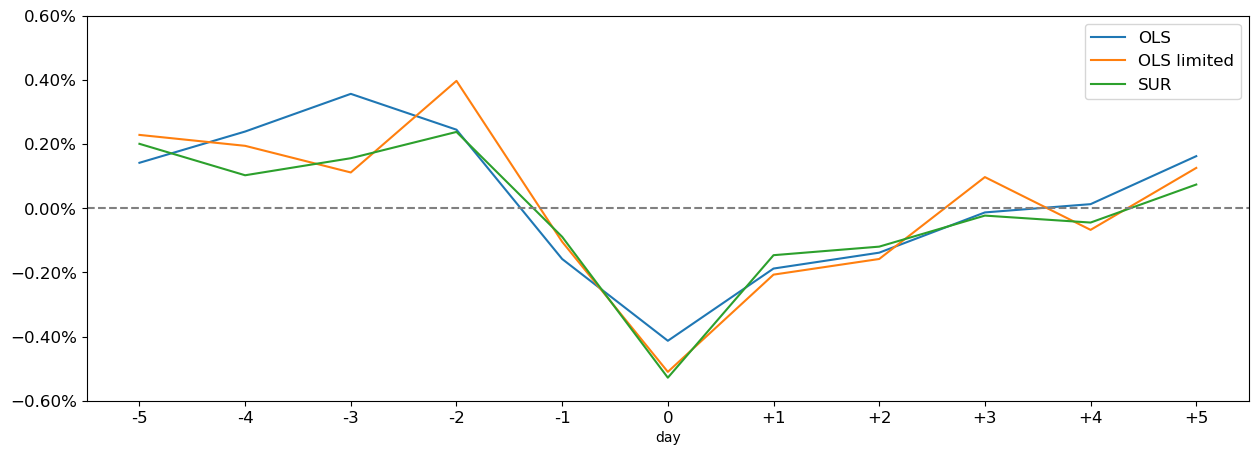

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15,5), sharex=True)

mean_daily_AR_OLS = AR_OLS.groupby('day').mean().params.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
mean_daily_AR_OLS *= 100
mean_daily_AR_OLS.plot(ax = ax, fontsize = 12)

mean_daily_AR_OLS_lim = AR_OLS_lim.groupby('day').mean().params.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
mean_daily_AR_OLS_lim *= 100
mean_daily_AR_OLS_lim.plot(ax = ax, fontsize = 12)

mean_daily_AR_SURE = AR_SURE.groupby('day').mean().params.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
mean_daily_AR_SURE *= 100
mean_daily_AR_SURE.plot(ax = ax, fontsize = 12)

ax.set_ylim([-0.6,0.6])
ax.set_xticks(range(-5,6),['-5','-4','-3','-2','-1','0','+1','+2','+3','+4','+5'])
ax.axhline(0, color='gray', linestyle='--')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#ax.title.set_text('Average abnormal returns')
ax.legend(['OLS','OLS limited','SUR'], fontsize = 12)

plt.show()

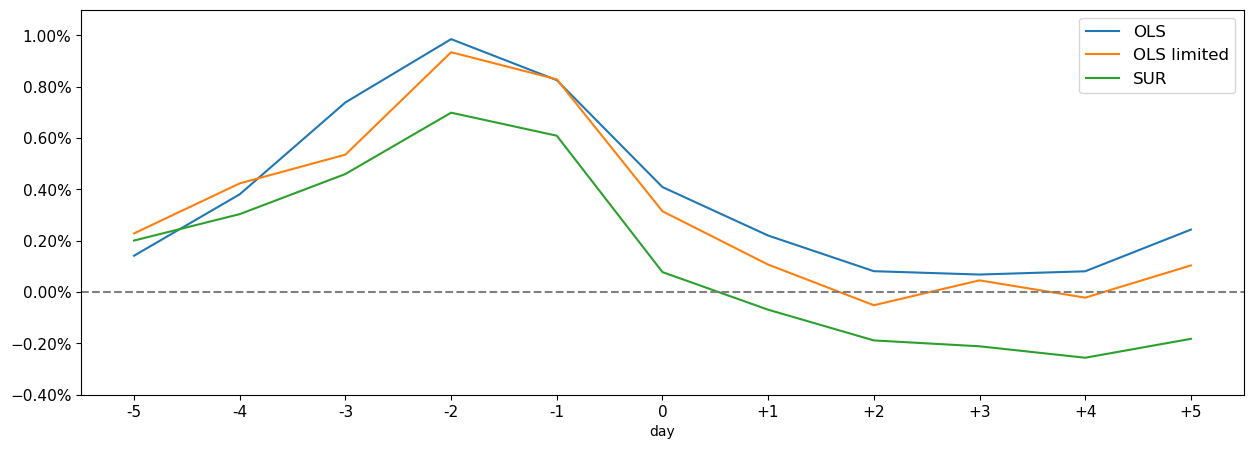

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(15,5), sharex=True)

cum_mean_daily_AR_OLS = (AR_OLS.groupby('day').mean().params+1)
cum_mean_daily_AR_OLS = cum_mean_daily_AR_OLS.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
cum_mean_daily_AR_OLS = cum_mean_daily_AR_OLS.cumprod()-1
cum_mean_daily_AR_OLS *= 100
cum_mean_daily_AR_OLS.plot(ax = ax, fontsize = 11)

cum_mean_daily_AR_OLS_lim = (AR_OLS_lim.groupby('day').mean().params+1)
cum_mean_daily_AR_OLS_lim = cum_mean_daily_AR_OLS_lim.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
cum_mean_daily_AR_OLS_lim = cum_mean_daily_AR_OLS_lim.cumprod()-1
cum_mean_daily_AR_OLS_lim *= 100
cum_mean_daily_AR_OLS_lim.plot(ax = ax, fontsize = 11)

cum_mean_daily_AR_SURE = (AR_SURE.groupby('day').mean().params+1)
cum_mean_daily_AR_SURE = cum_mean_daily_AR_SURE.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
cum_mean_daily_AR_SURE = cum_mean_daily_AR_SURE.cumprod()-1
cum_mean_daily_AR_SURE *= 100
cum_mean_daily_AR_SURE.plot(ax = ax, fontsize = 11)

ax.set_ylim([-0.4,1.1])
ax.set_xticks(range(-5,6),['-5','-4','-3','-2','-1','0','+1','+2','+3','+4','+5'])
ax.axhline(0, color='gray', linestyle='--')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#ax.title.set_text('Cumulative average abnormal returns')
ax.legend(['OLS','OLS limited','SUR'], fontsize = 12)

plt.show()

### Zero-benchmark

In [62]:
AR_OLS = pd.read_csv('../data/event_study/AR_OLS_0B.csv')
AR_OLS_lim = pd.read_csv('../data/event_study/AR_OLS_limited_0B.csv')
AR_SURE = pd.read_csv('../data/event_study/AR_SURE_0B.csv')

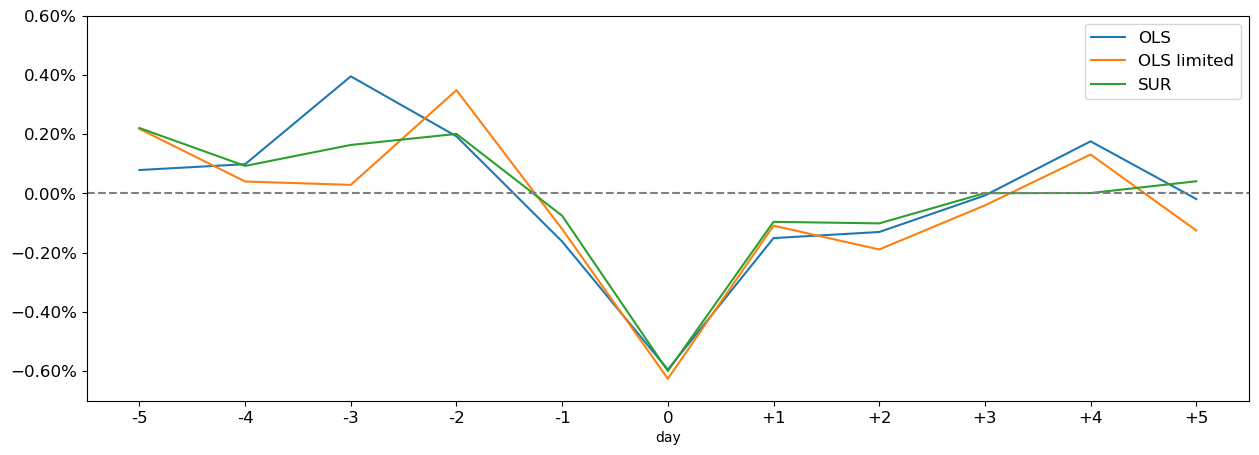

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15,5), sharex=True)

mean_daily_AR_OLS = AR_OLS.groupby('day').mean().params.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
mean_daily_AR_OLS *= 100
mean_daily_AR_OLS.plot(ax = ax, fontsize = 12)

mean_daily_AR_OLS_lim = AR_OLS_lim.groupby('day').mean().params.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
mean_daily_AR_OLS_lim *= 100
mean_daily_AR_OLS_lim.plot(ax = ax, fontsize = 12)

mean_daily_AR_SURE = AR_SURE.groupby('day').mean().params.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
mean_daily_AR_SURE *= 100
mean_daily_AR_SURE.plot(ax = ax, fontsize = 12)

ax.set_ylim([-0.7,0.6])
ax.set_xticks(range(-5,6),['-5','-4','-3','-2','-1','0','+1','+2','+3','+4','+5'])
ax.axhline(0, color='gray', linestyle='--')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#ax.title.set_text('Average abnormal returns')
ax.legend(['OLS','OLS limited','SUR'], fontsize = 12)

plt.show()

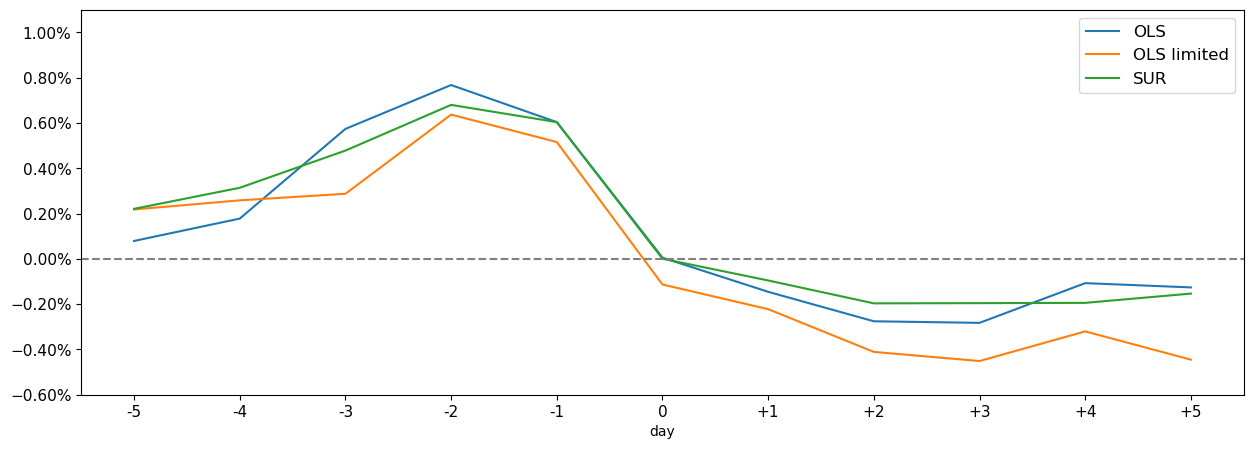

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(15,5), sharex=True)

cum_mean_daily_AR_OLS = (AR_OLS.groupby('day').mean().params+1)
cum_mean_daily_AR_OLS = cum_mean_daily_AR_OLS.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
cum_mean_daily_AR_OLS = cum_mean_daily_AR_OLS.cumprod()-1
cum_mean_daily_AR_OLS *= 100
cum_mean_daily_AR_OLS.plot(ax = ax, fontsize = 11)

cum_mean_daily_AR_OLS_lim = (AR_OLS_lim.groupby('day').mean().params+1)
cum_mean_daily_AR_OLS_lim = cum_mean_daily_AR_OLS_lim.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
cum_mean_daily_AR_OLS_lim = cum_mean_daily_AR_OLS_lim.cumprod()-1
cum_mean_daily_AR_OLS_lim *= 100
cum_mean_daily_AR_OLS_lim.plot(ax = ax, fontsize = 11)

cum_mean_daily_AR_SURE = (AR_SURE.groupby('day').mean().params+1)
cum_mean_daily_AR_SURE = cum_mean_daily_AR_SURE.loc[[-5,-4,-3,-2,-1,0,1,2,3,4,5]]
cum_mean_daily_AR_SURE = cum_mean_daily_AR_SURE.cumprod()-1
cum_mean_daily_AR_SURE *= 100
cum_mean_daily_AR_SURE.plot(ax = ax, fontsize = 11)

ax.set_ylim([-0.6,1.1])
ax.set_xticks(range(-5,6),['-5','-4','-3','-2','-1','0','+1','+2','+3','+4','+5'])
ax.axhline(0, color='gray', linestyle='--')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#ax.title.set_text('Cumulative average abnormal returns')
ax.legend(['OLS','OLS limited','SUR'], fontsize = 12)

plt.show()